In [8]:
import pandas as pd
import numpy as np
import sqlite3


In [9]:
# query = """
# SELECT
#     s.sensor_index,
#     s.name,
#     s.latitude,
#     s.longitude,
#     d.time_stamp,
#     d.humidity_a,
#     d.temperature_a,
#     d.pressure_a,
#     d."pm2.5_atm_a",
#     d."pm2.5_atm_b",
#     d."pm2.5_cf_1_a",
#     d."pm2.5_cf_1_b"
# FROM
#     sensor_table AS s
# JOIN
#     data_table AS d
# ON
#     s.sensor_index = d.sensor_index

# """

# with sqlite3.connect('../datasets/dallas.sqlite') as db:
#     data = pd.read_sql(query, db)

In [10]:
# data['time_stamp'] = pd.to_datetime(data['time_stamp'])

In [11]:
# data.set_index('time_stamp', inplace=True)
# data =  data.sort_index(ascending=True)


In [12]:
# data.index = data.index.date # change index to date format

In [13]:
# # Merging weather data from noaa to the data from a single sensor
# weather_noaa_data = pd.read_csv('../datasets/Dallas_stations_data.csv')

# weather_noaa_data_w =  weather_noaa_data[weather_noaa_data['STATION']=='USW00003971'][['STATION', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'DATE', 'AWND', 'DAPR', 'MDPR', 'PGTM', 'PRCP', 'SNOW', 'SNWD', 'TAVG','TMAX','TMIN', 'WDF2','WDF5', 'WESD', 'WESF','WSF2', 'WSF5', 'WT01', 'WT02', 'WT03', 'WT04', 'WT05', 'WT06','WT08']]

# weather_noaa_data_w_n = weather_noaa_data_w[:-2] # the noaa data is for two days longer

# weather_noaa_data_w_n = weather_noaa_data_w_n.fillna(0) # lot's of NAN values, which are essentially zeros

In [14]:
# weather_noaa_data_w_n['DATE'] = pd.to_datetime(weather_noaa_data_w_n['DATE'])
# weather_noaa_data_w_n.set_index('DATE', inplace=True) # setting index makes it easier to merge later

In [15]:
# merged_df = pd.merge(data, weather_noaa_data_w_n, how = 'left', left_index=True, right_index=True)

In [16]:
# start_date = '2022-04-01'
# end_date = '2024-03-29'

# # Filter the DataFrame for rows within the specified range
# filtered_merged_df = merged_df[(merged_df.index >= start_date) & (merged_df.index <= end_date)]


In [17]:
# Reset the index and rename the index column
# filtered_merged_df = filtered_merged_df.reset_index().rename(columns={'index': 'time_stamp'})

In [18]:
# filtered_merged_df

In [19]:
# filtered_merged_df = filtered_merged_df[filtered_merged_df['pm2.5_atm_a']<1000]

In [20]:
# filtered_merged_df

In [21]:
# filtered_merged_df.to_csv('../datasets/merged_data_CNN.csv', index=False)

In [22]:
filtered_merged_df = pd.read_csv('../datasets/merged_data_CNN.csv', index_col=False)

In [23]:
filtered_merged_df

,time_stamp,sensor_index,name,latitude,longitude,humidity_a,temperature_a,pressure_a,pm2.5_atm_a,pm2.5_atm_b,...,WESF,WSF2,WSF5,WT01,WT02,WT03,WT04,WT05,WT06,WT08
0,2022-04-01,87721,Garland,32.963880,-96.634650,31.406,66.424,996.667,4.720,3.450,...,0.0,11.2,13.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2022-04-01,90785,HeathWeather,32.819980,-96.466545,39.826,61.796,998.508,3.981,3.353,...,0.0,11.2,13.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2022-04-01,113708,UNT-GEO-56,33.259953,-97.257290,42.803,59.520,990.216,1.014,1.565,...,0.0,11.2,13.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2022-04-01,127067,UNT-GEO-39,33.149710,-97.126010,38.254,62.729,995.100,0.373,0.606,...,0.0,11.2,13.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2022-04-01,59903,UNT-GEO-32,33.112953,-97.121280,33.125,66.057,994.619,3.595,4.456,...,0.0,11.2,13.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39792,2024-03-29,113969,UNT-GEO-58,33.114075,-97.365974,75.111,68.013,988.733,0.845,3298.304,...,0.0,13.9,19.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39793,2024-03-29,99585,Aldersyde,32.921955,-97.305560,72.486,73.772,989.039,2.805,4.284,...,0.0,13.9,19.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39794,2024-03-29,114119,UNT-GEO-44,33.238647,-97.109695,46.908,72.577,992.503,0.796,1.034,...,0.0,13.9,19.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39795,2024-03-29,144032,LOCHWOOD,32.861404,-96.687240,49.159,72.571,996.867,5.734,5.654,...,0.0,13.9,19.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
filtered_merged_df['pm2.5_atm_a'].values.min()

0.0

In [25]:
from scipy.interpolate import griddata
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense

from sklearn.model_selection import train_test_split


# Function to convert latitude and longitude to Cartesian coordinates
def lat_lon_to_cartesian(lat, lon, radius=6371.0):
    x = radius * np.cos(lat) * np.cos(lon)
    y = radius * np.cos(lat) * np.sin(lon)
    z = radius * np.sin(lat)
    return x, y, z

# Function to create a spatial map for a given timestamp
def create_spatial_map(data, timestamp, grid_x, grid_y):
    subset = data[data['time_stamp'] == timestamp]
    lat = np.radians(subset['latitude'].values)
    lon = np.radians(subset['longitude'].values)
    values = subset['pm2.5_atm_a'].values

    # Convert latitude and longitude to Cartesian coordinates
    cartesian_points = np.array([lat_lon_to_cartesian(lat_i, lon_i) for lat_i, lon_i in zip(lat, lon)])

    # Ensure cartesian_points has the correct shape
    cartesian_points = cartesian_points.reshape(-1, 3)

    # Interpolate using griddata
    grid_z = griddata(cartesian_points[:, :2], values, (grid_x, grid_y), method='cubic')
    grid_z__clipped = np.clip(grid_z, 0, None)
    

    return grid_z__clipped

# Example dataset ranges
min_latitude = filtered_merged_df['latitude'].min()
max_latitude = filtered_merged_df['latitude'].max()
min_longitude = filtered_merged_df['longitude'].min()
max_longitude = filtered_merged_df['longitude'].max()

# Convert min and max latitude and longitude to radians
min_lat_rad = np.radians(min_latitude)
max_lat_rad = np.radians(max_latitude)
min_lon_rad = np.radians(min_longitude)
max_lon_rad = np.radians(max_longitude)

# Convert the bounding coordinates to Cartesian coordinates
min_x, min_y, _ = lat_lon_to_cartesian(min_lat_rad, min_lon_rad)
max_x, max_y, _ = lat_lon_to_cartesian(max_lat_rad, max_lon_rad)

# Define grid resolution (in Cartesian coordinates)
x_resolution = (max_x - min_x) / 100
y_resolution = (max_y - min_y) / 100

# Create grid points in Cartesian coordinates
grid_x, grid_y = np.meshgrid(np.arange(min_x, max_x, x_resolution), np.arange(min_y, max_y, y_resolution))

# Generate spatial maps for all timestamps
timestamps = filtered_merged_df['time_stamp'].unique()
spatial_maps = [create_spatial_map(filtered_merged_df, ts, grid_x, grid_y) for ts in timestamps]
spatial_maps = np.array(spatial_maps)


# Normalize the spatial maps
spatial_maps = spatial_maps / np.nanmax(spatial_maps)

# Handle potential NaNs in spatial maps
spatial_maps = np.nan_to_num(spatial_maps)

2024-06-06 09:37:13.173451: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-06 09:37:13.329446: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-06 09:37:13.942399: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-06 09:37:15.777976: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [26]:
# Flatten the grid coordinates for easier association
grid_coordinates = np.column_stack((grid_x.ravel(), grid_y.ravel()))

In [28]:
len(spatial_maps)

729

In [29]:
time_steps = 10
X, y = [], []
for i in range(len(spatial_maps) - time_steps):
    X.append(spatial_maps[i:i + time_steps])
    y.append(spatial_maps[i + time_steps])

X = np.array(X)[..., np.newaxis]
y = np.array(y)[..., np.newaxis]
y = y.reshape(y.shape[0], -1)

In [30]:
len(X)

719

In [31]:
# Train-test split
split_index = int(0.9 * len(X))  # 90% of the data for training, 10% for testing
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [32]:
len(X_train)

647

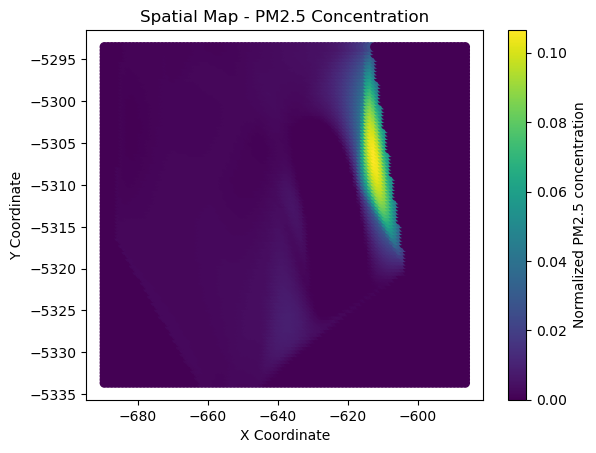

In [21]:
import matplotlib.pyplot as plt

# Select a specific timestamp
timestamp_index = 3

# Plot the PM2.5 values with their corresponding coordinates
plt.scatter(grid_coordinates[:, 0], grid_coordinates[:, 1], c=spatial_maps[timestamp_index].ravel(), cmap='viridis')
plt.colorbar(label='Normalized PM2.5 concentration')
plt.title('Spatial Map - PM2.5 Concentration')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()


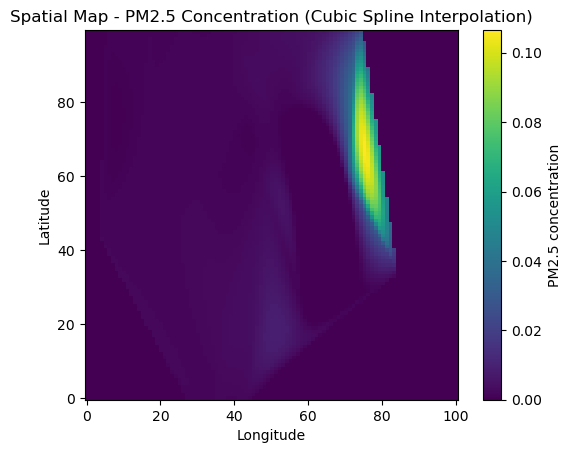

In [22]:
import matplotlib.pyplot as plt
plt.imshow(spatial_maps[3], origin='lower', cmap='viridis')
plt.colorbar(label='PM2.5 concentration')
plt.title('Spatial Map - PM2.5 Concentration (Cubic Spline Interpolation)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [23]:
time_steps = 10
X = []
y = []

for i in range(len(spatial_maps) - time_steps):
    X.append(spatial_maps[i:i + time_steps])
    y.append(spatial_maps[i + time_steps])

X = np.array(X)
y = np.array(y)
X.shape
X = X[..., np.newaxis]
y = y[..., np.newaxis]

y = y.reshape(y.shape[0], -1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape
model = Sequential()
model.add(Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', input_shape=(time_steps, 100, 101, 1), padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu', padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
# Change the output layer to match the shape of your target variable
model.add(Dense(100*101*1, activation='linear'))
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

/home/prahlad/anaconda3/envs/pyml/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [24]:
# Print the model summary
model.summary()
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 10, 100, 101,   │           896 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 5, 50, 50, 32)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 5, 50, 50, 64)  │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 2, 25, 25, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 80000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    10,240,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10100)          │     1,302,900 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,599,284 (44.25 MB)

 Trainable params: 11,599,284 (44.25 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


2024-06-01 22:41:59.142160: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 413696000 exceeds 10% of free system memory.
2024-06-01 22:42:04.157664: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 413696000 exceeds 10% of free system memory.


 1/15 ━━━━━━━━━━━━━━━━━━━━ 3:00 13s/step - loss: 0.0107

2024-06-01 22:42:10.425546: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 413696000 exceeds 10% of free system memory.
2024-06-01 22:42:14.723605: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 413696000 exceeds 10% of free system memory.


 2/15 ━━━━━━━━━━━━━━━━━━━━ 2:20 11s/step - loss: 0.0114

2024-06-01 22:42:21.212784: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 413696000 exceeds 10% of free system memory.


15/15 ━━━━━━━━━━━━━━━━━━━━ 151s 10s/step - loss: 0.0093 - val_loss: 0.0020
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 142s 9s/step - loss: 0.0018 - val_loss: 0.0013
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 142s 9s/step - loss: 0.0012 - val_loss: 9.5756e-04
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 143s 9s/step - loss: 7.6143e-04 - val_loss: 6.0908e-04
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 142s 9s/step - loss: 5.0112e-04 - val_loss: 4.7754e-04
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 140s 9s/step - loss: 3.2402e-04 - val_loss: 3.8104e-04
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 140s 9s/step - loss: 2.7679e-04 - val_loss: 3.4971e-04
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 140s 9s/step - loss: 2.3883e-04 - val_loss: 3.3065e-04
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 137s 9s/step - loss: 2.3894e-04 - val_loss: 2.7622e-04
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 121s 8s/step - loss: 2.0623e-04 - val_loss: 3.1366e-04


In [25]:
# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f"Test loss: {loss}")
# model.save('3dcnn_model.h5')

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 793ms/step - loss: 3.0273e-04
Test loss: 0.0003150711127091199


In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
# Make predictions
y_pred = model.predict(X_test)

# Reshape predictions to the original 2D shape for visualization
y_pred_reshaped = y_pred.reshape(-1, 100, 101)
y_test_reshaped = y_test.reshape(-1, 100, 101)

# Calculate additional performance metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 793ms/step
Mean Squared Error: 0.00031507112205260163
Root Mean Squared Error: 0.017750242873059558
Mean Absolute Error: 0.005796775267399496


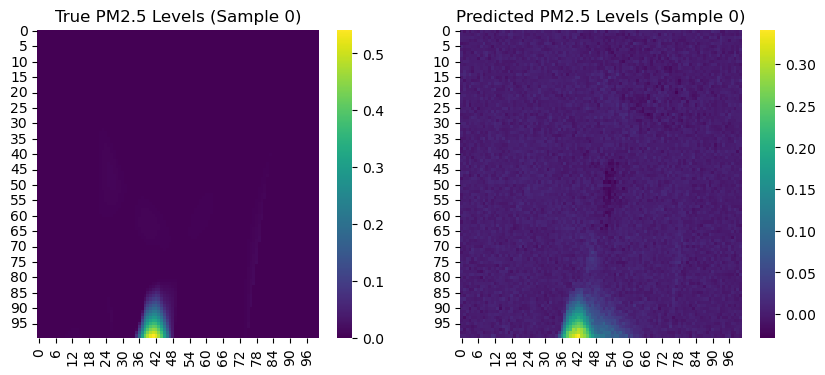

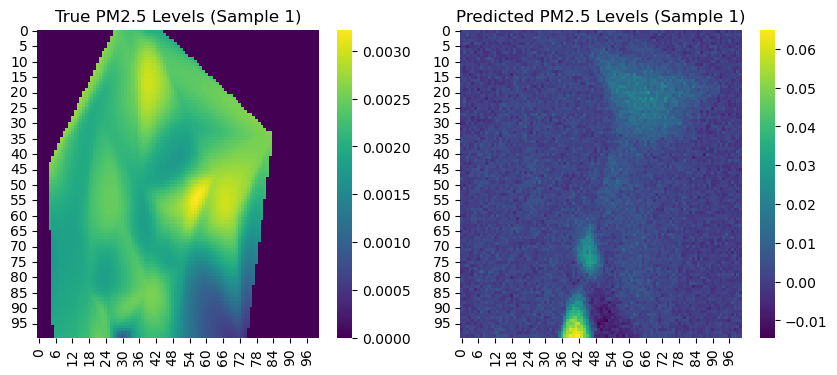

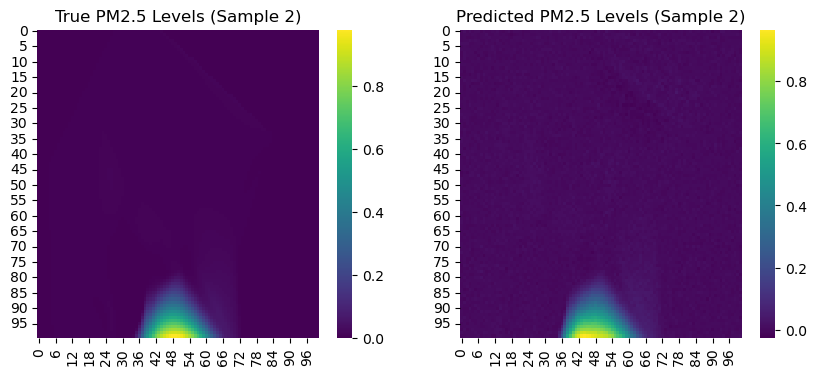

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
num_samples = 3
for i in range(num_samples):
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.title(f'True PM2.5 Levels (Sample {i})')
    sns.heatmap(y_test_reshaped[i], cmap='viridis', cbar=True)

    plt.subplot(1, 2, 2)
    plt.title(f'Predicted PM2.5 Levels (Sample {i})')
    sns.heatmap(y_pred_reshaped[i], cmap='viridis', cbar=True)

    plt.show()

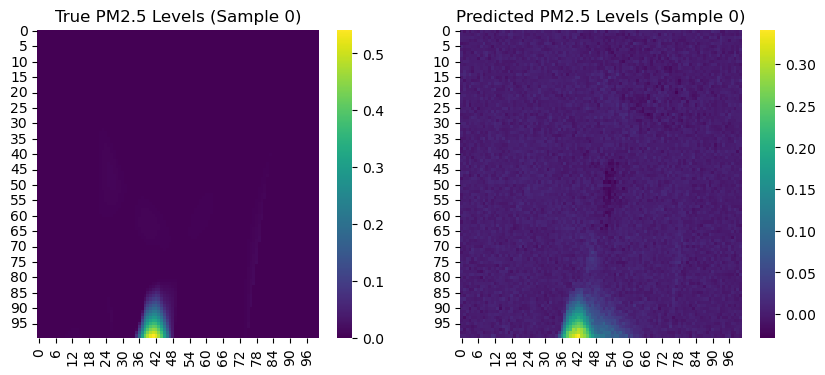

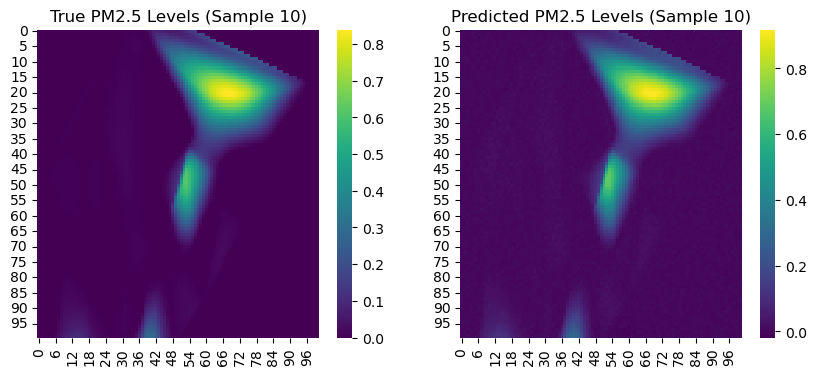

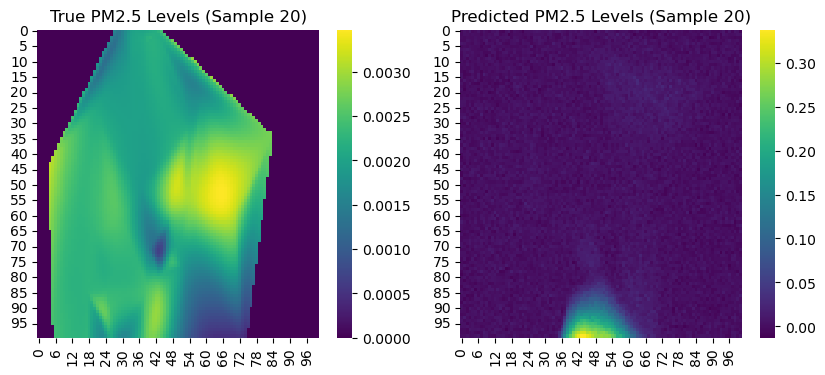

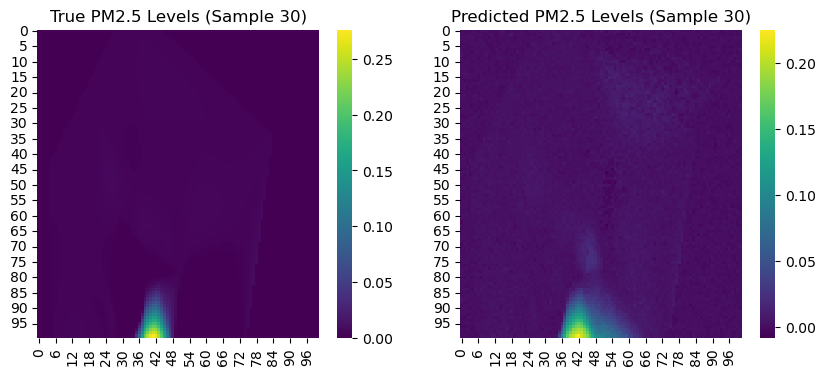

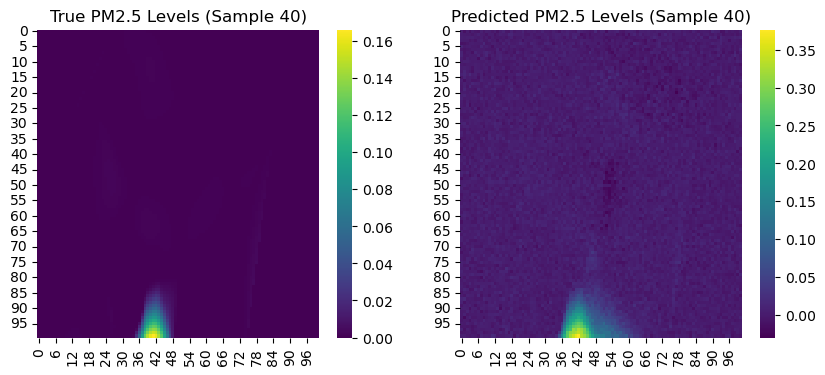

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
num_samples = 5
for i in range(0, num_samples*10,10):
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.title(f'True PM2.5 Levels (Sample {i})')
    sns.heatmap(y_test_reshaped[i], cmap='viridis', cbar=True)

    plt.subplot(1, 2, 2)
    plt.title(f'Predicted PM2.5 Levels (Sample {i})')
    sns.heatmap(y_pred_reshaped[i], cmap='viridis', cbar=True)

    plt.show()

In [29]:
grid_x

array([[-689.50040596, -688.47048317, -687.44056038, ..., -588.56797288,
        -587.5380501 , -586.50812731],
       [-689.50040596, -688.47048317, -687.44056038, ..., -588.56797288,
        -587.5380501 , -586.50812731],
       [-689.50040596, -688.47048317, -687.44056038, ..., -588.56797288,
        -587.5380501 , -586.50812731],
       ...,
       [-689.50040596, -688.47048317, -687.44056038, ..., -588.56797288,
        -587.5380501 , -586.50812731],
       [-689.50040596, -688.47048317, -687.44056038, ..., -588.56797288,
        -587.5380501 , -586.50812731],
       [-689.50040596, -688.47048317, -687.44056038, ..., -588.56797288,
        -587.5380501 , -586.50812731]])

In [30]:
y_pred_reshaped.shape

(144, 100, 101)

In [31]:
len(filtered_merged_df['time_stamp'].unique())

729

In [32]:
unique_sensor_locs = filtered_merged_df[['latitude', 'longitude']].drop_duplicates().values

In [33]:
len(unique_sensor_locs)

67

In [34]:
from scipy.interpolate import griddata

lat = np.radians(unique_sensor_locs[:, 0])
lon = np.radians(unique_sensor_locs[:, 1])

sensor_cartesian_points = np.array([lat_lon_to_cartesian(lat_i, lon_i) for lat_i, lon_i in zip(lat, lon)])
sensor_cartesian_points = sensor_cartesian_points.reshape(-1, 3)




In [35]:
sensor_cartesian_points

array([[ -617.5911588 , -5309.55914088,  3466.52619925],
       [ -602.98898029, -5319.98241754,  3453.09026333],
       [ -672.98128193, -5284.69401718,  3494.10164977],
       [ -661.70365335, -5292.88341724,  3483.84477362],
       [ -661.54363808, -5295.15468866,  3480.42207758],
       [ -669.59127204, -5307.53465742,  3459.96595196],
       [ -644.96831919, -5301.0231653 ,  3474.59497902],
       [ -686.08541389, -5316.02472877,  3443.66213325],
       [ -684.14289989, -5292.21354889,  3480.52657588],
       [ -636.75829954, -5302.59005188,  3473.71826861],
       [ -655.12171407, -5334.12971882,  3421.62485999],
       [ -663.24132239, -5291.28046278,  3485.98666269],
       [ -642.72783898, -5303.61827204,  3471.04813414],
       [ -663.73274197, -5288.0734775 ,  3490.7561851 ],
       [ -662.66127526, -5292.17647854,  3484.73659755],
       [ -649.89858693, -5299.70541723,  3475.68630881],
       [ -650.28552191, -5331.76237943,  3426.23403597],
       [ -649.22641036, -5304.9

In [36]:
y_pred.shape

(144, 10100)

In [37]:
predicted_sensor_values = griddata(
    (grid_coordinates[:, 0], grid_coordinates[:, 1]),
    y_pred[0],  
    sensor_cartesian_points[:, :2], 
    method='linear'
)

In [38]:
predicted_sensor_values[0]

0.005455640359379937

In [39]:
observed_sensor_values = griddata(
    (grid_coordinates[:, 0], grid_coordinates[:, 1]),
    y_test[0],  
    sensor_cartesian_points[:, :2], 
    method='linear'
)

In [40]:
values_list = []
# Iterate through sensor locations and predicted values
for i, (lat, lon) in enumerate(unique_sensor_locs):
    predicted_pm25 = predicted_sensor_values[i]
    observed_pm25 = observed_sensor_values[i]
    values_list.append({'Latitude': lat, 'Longitude': lon, 'Predicted_PM2.5': predicted_pm25, 'Observed_PM2.5': observed_pm25})
    

pm_values_df = pd.DataFrame(values_list)

# Display the DataFrame
print(pm_values_df)

     Latitude  Longitude  Predicted_PM2.5  Observed_PM2.5
0   32.963880 -96.634650         0.005456    5.786111e-04
1   32.819980 -96.466545         0.002188    6.355352e-07
2   33.259953 -97.257290              NaN             NaN
3   33.149710 -97.126010              NaN             NaN
4   33.112953 -97.121280        -0.000331    1.503036e-03
..        ...        ...              ...             ...
62  33.133965 -96.765780         0.001731    0.000000e+00
63  32.960114 -96.692200         0.005455    1.172414e-03
64  32.977444 -96.776110         0.005785    2.549946e-03
65  33.126100 -97.059390        -0.005424    0.000000e+00
66  32.456380 -97.006840              NaN             NaN

[67 rows x 4 columns]


In [41]:
# Round both columns to the same significant digits, e.g., 2 significant digits
pm_values_df['Predicted_PM2.5'] = pm_values_df['Predicted_PM2.5'].apply(lambda x: round(x, 5))
pm_values_df['Observed_PM2.5'] = pm_values_df['Observed_PM2.5'].apply(lambda x: round(x, 5))

pm_values_df['Absolute_Error'] = (pm_values_df['Predicted_PM2.5'] - pm_values_df['Observed_PM2.5']).abs()
pm_values_df['Squared_Error'] = (pm_values_df['Predicted_PM2.5'] - pm_values_df['Observed_PM2.5']) ** 2
pm_values_df['Percentage_Error'] = (pm_values_df['Absolute_Error'] / pm_values_df['Observed_PM2.5']).abs() * 100

# Display the DataFrame
print(pm_values_df)

     Latitude  Longitude  Predicted_PM2.5  Observed_PM2.5  Absolute_Error  \
0   32.963880 -96.634650          0.00546         0.00058         0.00488   
1   32.819980 -96.466545          0.00219         0.00000         0.00219   
2   33.259953 -97.257290              NaN             NaN             NaN   
3   33.149710 -97.126010              NaN             NaN             NaN   
4   33.112953 -97.121280         -0.00033         0.00150         0.00183   
..        ...        ...              ...             ...             ...   
62  33.133965 -96.765780          0.00173         0.00000         0.00173   
63  32.960114 -96.692200          0.00545         0.00117         0.00428   
64  32.977444 -96.776110          0.00579         0.00255         0.00324   
65  33.126100 -97.059390         -0.00542         0.00000         0.00542   
66  32.456380 -97.006840              NaN             NaN             NaN   

    Squared_Error  Percentage_Error  
0        0.000024        841.379310  

In [38]:
len(X_train)

647

In [39]:
from datetime import datetime, timedelta

# Define the initial date and the end date
start_date = datetime.strptime('2022-04-01', '%Y-%m-%d')
end_date = datetime.strptime('2024-03-29', '%Y-%m-%d')

# Calculate the 648th day
day_zero = start_date + timedelta(days=len(X_train))

# Generate a list of dates from day_648 to end_date
current_date = day_zero
dates = []

while current_date <= end_date:
    dates.append(current_date.strftime('%Y-%m-%d'))
    current_date += timedelta(days=1)

# Return the list of dates
dates

['2024-01-08',
 '2024-01-09',
 '2024-01-10',
 '2024-01-11',
 '2024-01-12',
 '2024-01-13',
 '2024-01-14',
 '2024-01-15',
 '2024-01-16',
 '2024-01-17',
 '2024-01-18',
 '2024-01-19',
 '2024-01-20',
 '2024-01-21',
 '2024-01-22',
 '2024-01-23',
 '2024-01-24',
 '2024-01-25',
 '2024-01-26',
 '2024-01-27',
 '2024-01-28',
 '2024-01-29',
 '2024-01-30',
 '2024-01-31',
 '2024-02-01',
 '2024-02-02',
 '2024-02-03',
 '2024-02-04',
 '2024-02-05',
 '2024-02-06',
 '2024-02-07',
 '2024-02-08',
 '2024-02-09',
 '2024-02-10',
 '2024-02-11',
 '2024-02-12',
 '2024-02-13',
 '2024-02-14',
 '2024-02-15',
 '2024-02-16',
 '2024-02-17',
 '2024-02-18',
 '2024-02-19',
 '2024-02-20',
 '2024-02-21',
 '2024-02-22',
 '2024-02-23',
 '2024-02-24',
 '2024-02-25',
 '2024-02-26',
 '2024-02-27',
 '2024-02-28',
 '2024-02-29',
 '2024-03-01',
 '2024-03-02',
 '2024-03-03',
 '2024-03-04',
 '2024-03-05',
 '2024-03-06',
 '2024-03-07',
 '2024-03-08',
 '2024-03-09',
 '2024-03-10',
 '2024-03-11',
 '2024-03-12',
 '2024-03-13',
 '2024-03-

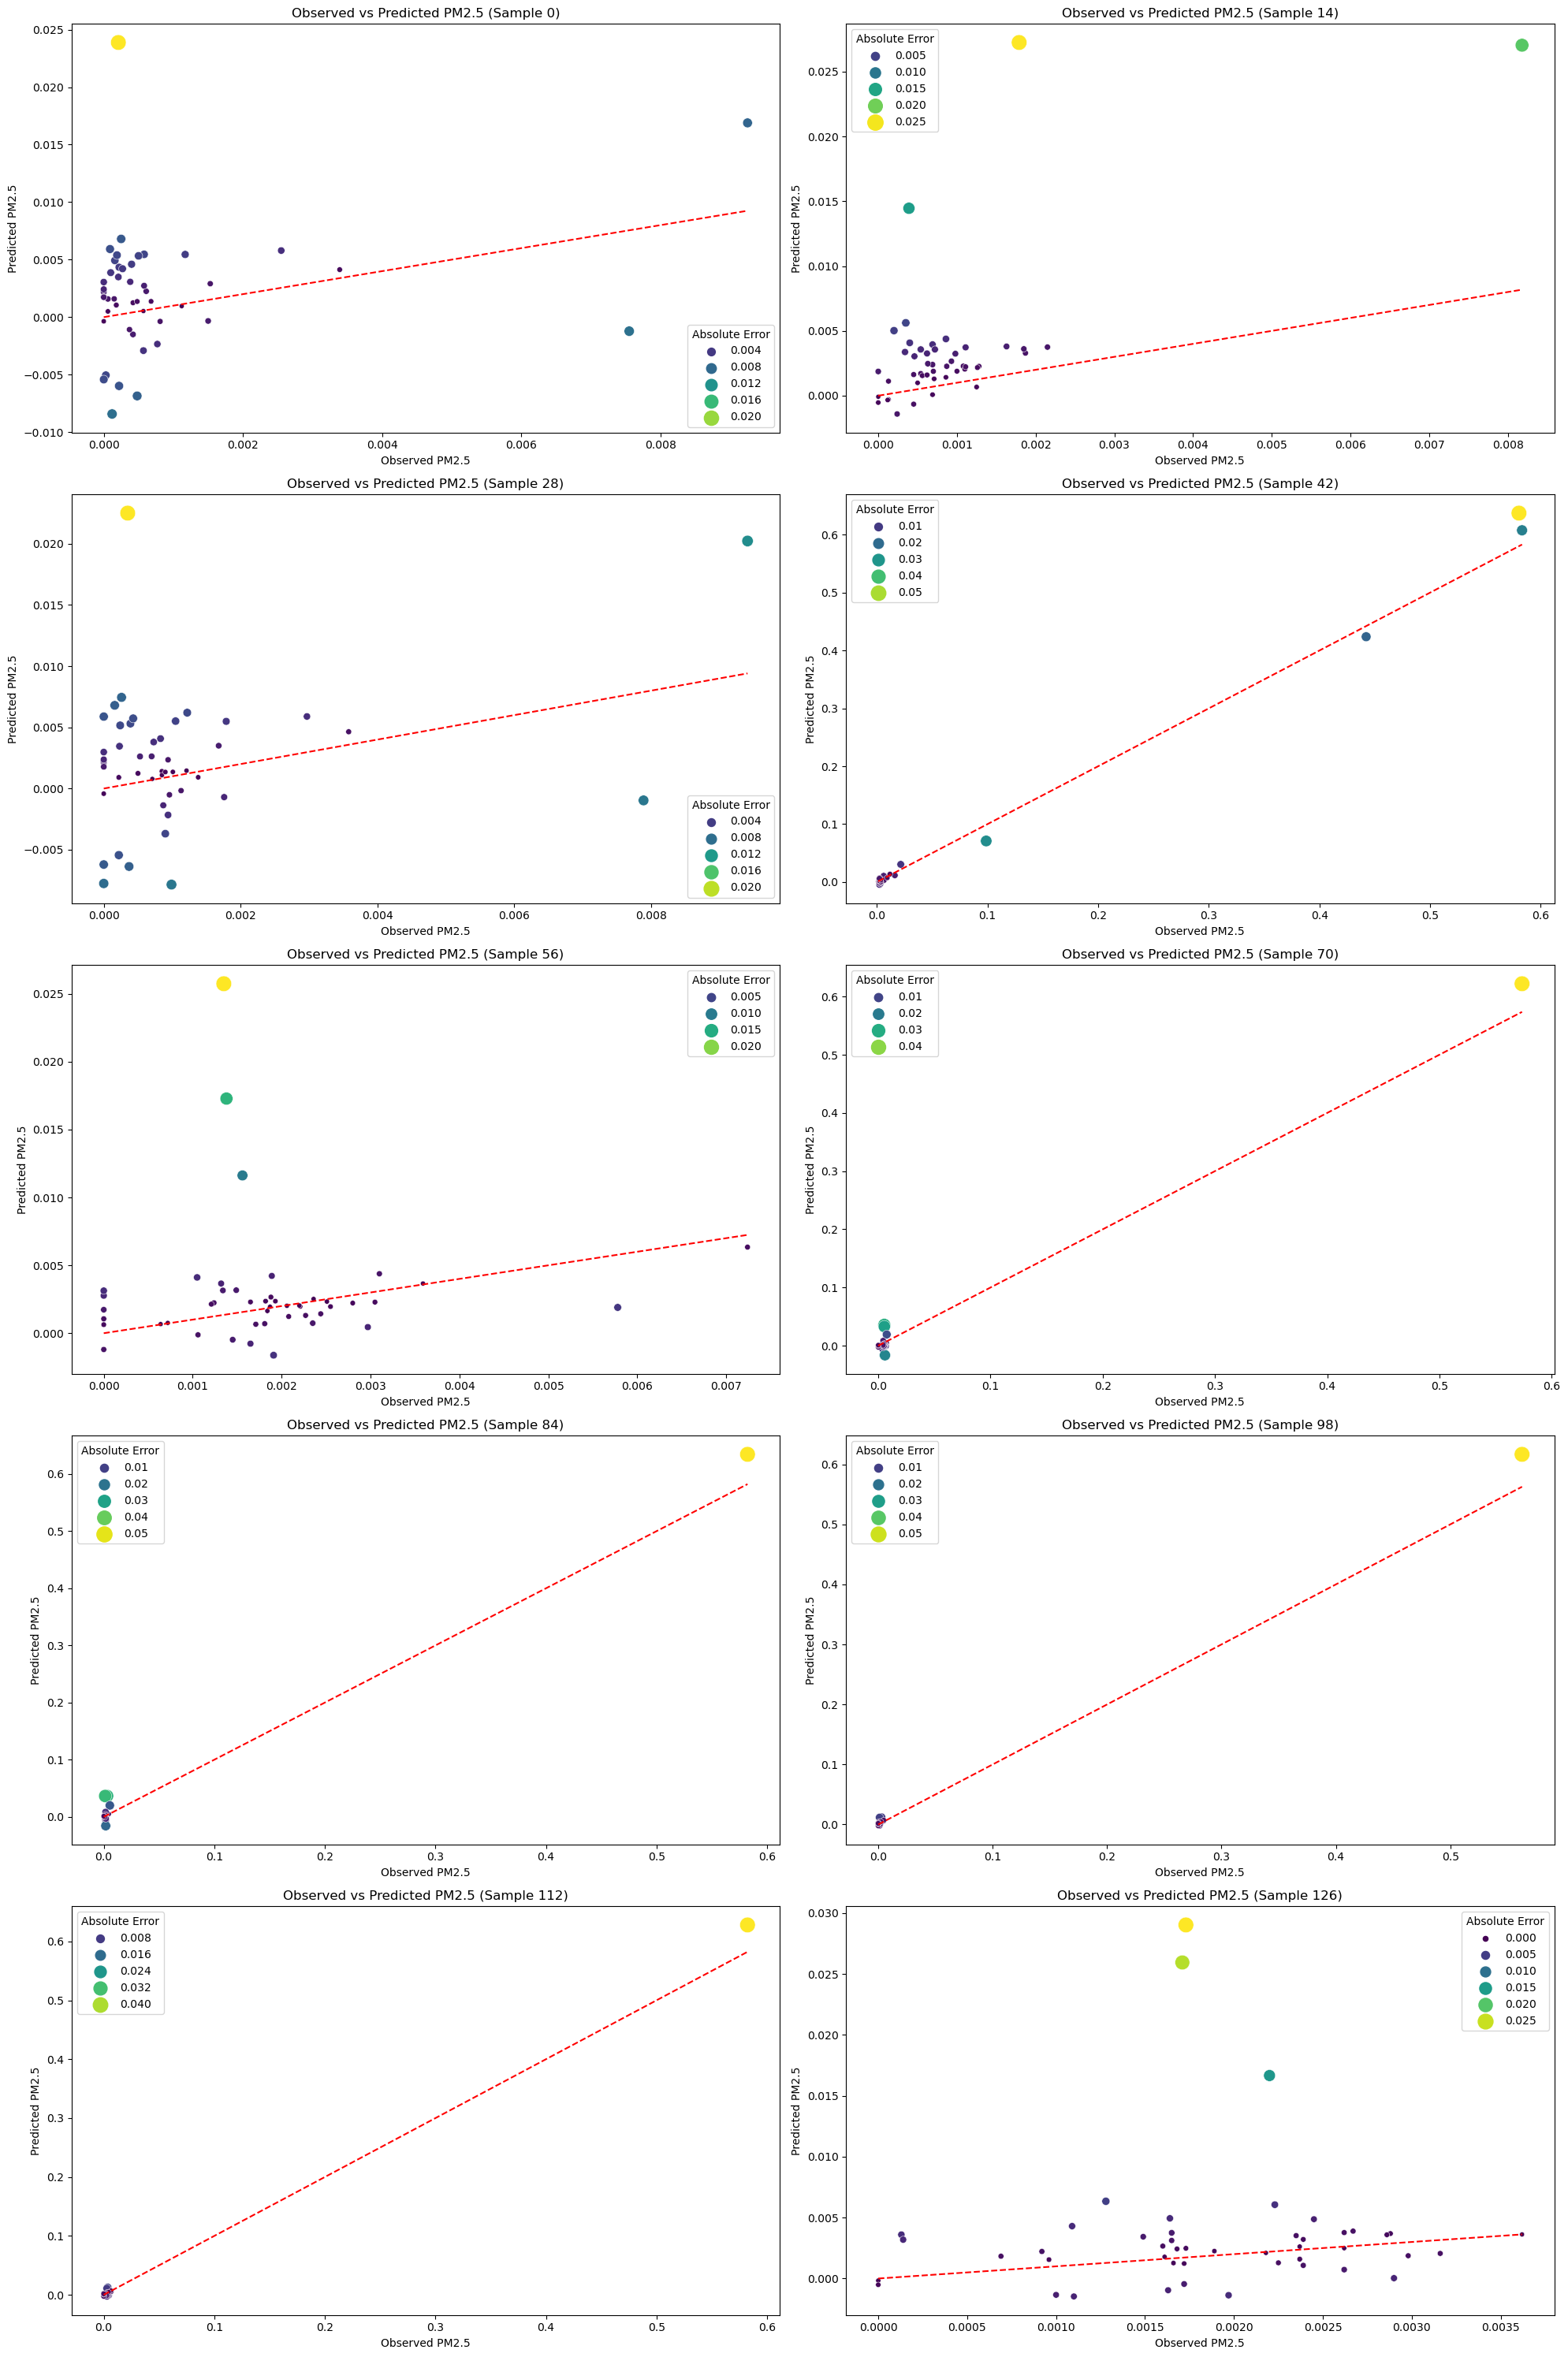

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import seaborn as sns

num_samples = 10
step_size = 14  # Set the step size to 11
rows = (num_samples + 1) // 2  # Calculate number of rows needed for 2 plots per row

fig, axes = plt.subplots(rows, 2, figsize=(20, 6 * rows))
axes = axes.flatten()  # Flatten the axes array for easy iteration

for idx, i in enumerate(range(0, num_samples * step_size, step_size)):
    predicted_sensor_values = griddata(
        (grid_coordinates[:, 0], grid_coordinates[:, 1]),
        y_pred[i],  
        sensor_cartesian_points[:, :2], 
        method='linear'
    )
    observed_sensor_values = griddata(
        (grid_coordinates[:, 0], grid_coordinates[:, 1]),
        y_test[i],  
        sensor_cartesian_points[:, :2], 
        method='linear'
    )
    values_list = []
    # Iterate through sensor locations and predicted values
    for j, (lat, lon) in enumerate(unique_sensor_locs):
        predicted_pm25 = predicted_sensor_values[j]
        observed_pm25 = observed_sensor_values[j]
        values_list.append({'Latitude': lat, 'Longitude': lon, 'Predicted_PM2.5': predicted_pm25, 'Observed_PM2.5': observed_pm25})

    pm_values_df = pd.DataFrame(values_list)

    # Round both columns to the same significant digits, e.g., 5 significant digits
    pm_values_df['Predicted_PM2.5'] = pm_values_df['Predicted_PM2.5'].apply(lambda x: round(x, 5))
    pm_values_df['Observed_PM2.5'] = pm_values_df['Observed_PM2.5'].apply(lambda x: round(x, 5))

    pm_values_df['Absolute_Error'] = (pm_values_df['Predicted_PM2.5'] - pm_values_df['Observed_PM2.5']).abs()
    pm_values_df['Squared_Error'] = (pm_values_df['Predicted_PM2.5'] - pm_values_df['Observed_PM2.5']) ** 2
    pm_values_df['Percentage_Error'] = (pm_values_df['Absolute_Error'] / pm_values_df['Observed_PM2.5']).abs() * 100

    # Scatter plot of observed vs predicted values
    sns.scatterplot(ax=axes[idx], x='Observed_PM2.5', y='Predicted_PM2.5', data=pm_values_df, hue='Absolute_Error', palette='viridis', size='Absolute_Error', sizes=(20, 200))
    axes[idx].plot([pm_values_df['Observed_PM2.5'].min(), pm_values_df['Observed_PM2.5'].max()], [pm_values_df['Observed_PM2.5'].min(), pm_values_df['Observed_PM2.5'].max()], color='red', linestyle='--')
    axes[idx].set_title(f'Observed vs Predicted PM2.5 (Sample {i})')
    axes[idx].set_xlabel('Observed PM2.5')
    axes[idx].set_ylabel('Predicted PM2.5')
    axes[idx].legend(title='Absolute Error')

# Remove any unused subplots
for ax in axes[len(range(0, num_samples * step_size, step_size)):]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()


In [5]:
import pandas as pd
results_data = pd.read_csv('../models/3DCNN_model_resultspredicted_vs_observed.csv', index_col=False)

In [6]:
results_data

,Latitude,Longitude,Predicted_PM2.5,Observed_PM2.5,Absolute_Error,Squared_Error,Percentage_Error
0,32.963880,-96.634650,0.01248,0.00209,0.01039,1.079521e-04,497.129187
1,32.819980,-96.466545,-0.00388,0.00379,0.00767,5.882890e-05,202.374670
2,33.259953,-97.257290,NaN,NaN,NaN,NaN,NaN
3,33.149710,-97.126010,NaN,NaN,NaN,NaN,NaN
4,33.112953,-97.121280,-0.00372,0.00080,0.00452,2.043040e-05,565.000000
...,...,...,...,...,...,...,...
62,33.133965,-96.765780,0.00094,0.00048,0.00046,2.116000e-07,95.833333
63,32.960114,-96.692200,0.01239,0.00239,0.01000,1.000000e-04,418.410042
64,32.977444,-96.776110,0.01093,0.01014,0.00079,6.241000e-07,7.790927
65,33.126100,-97.059390,-0.01595,0.00126,0.01721,2.961841e-04,1365.873016


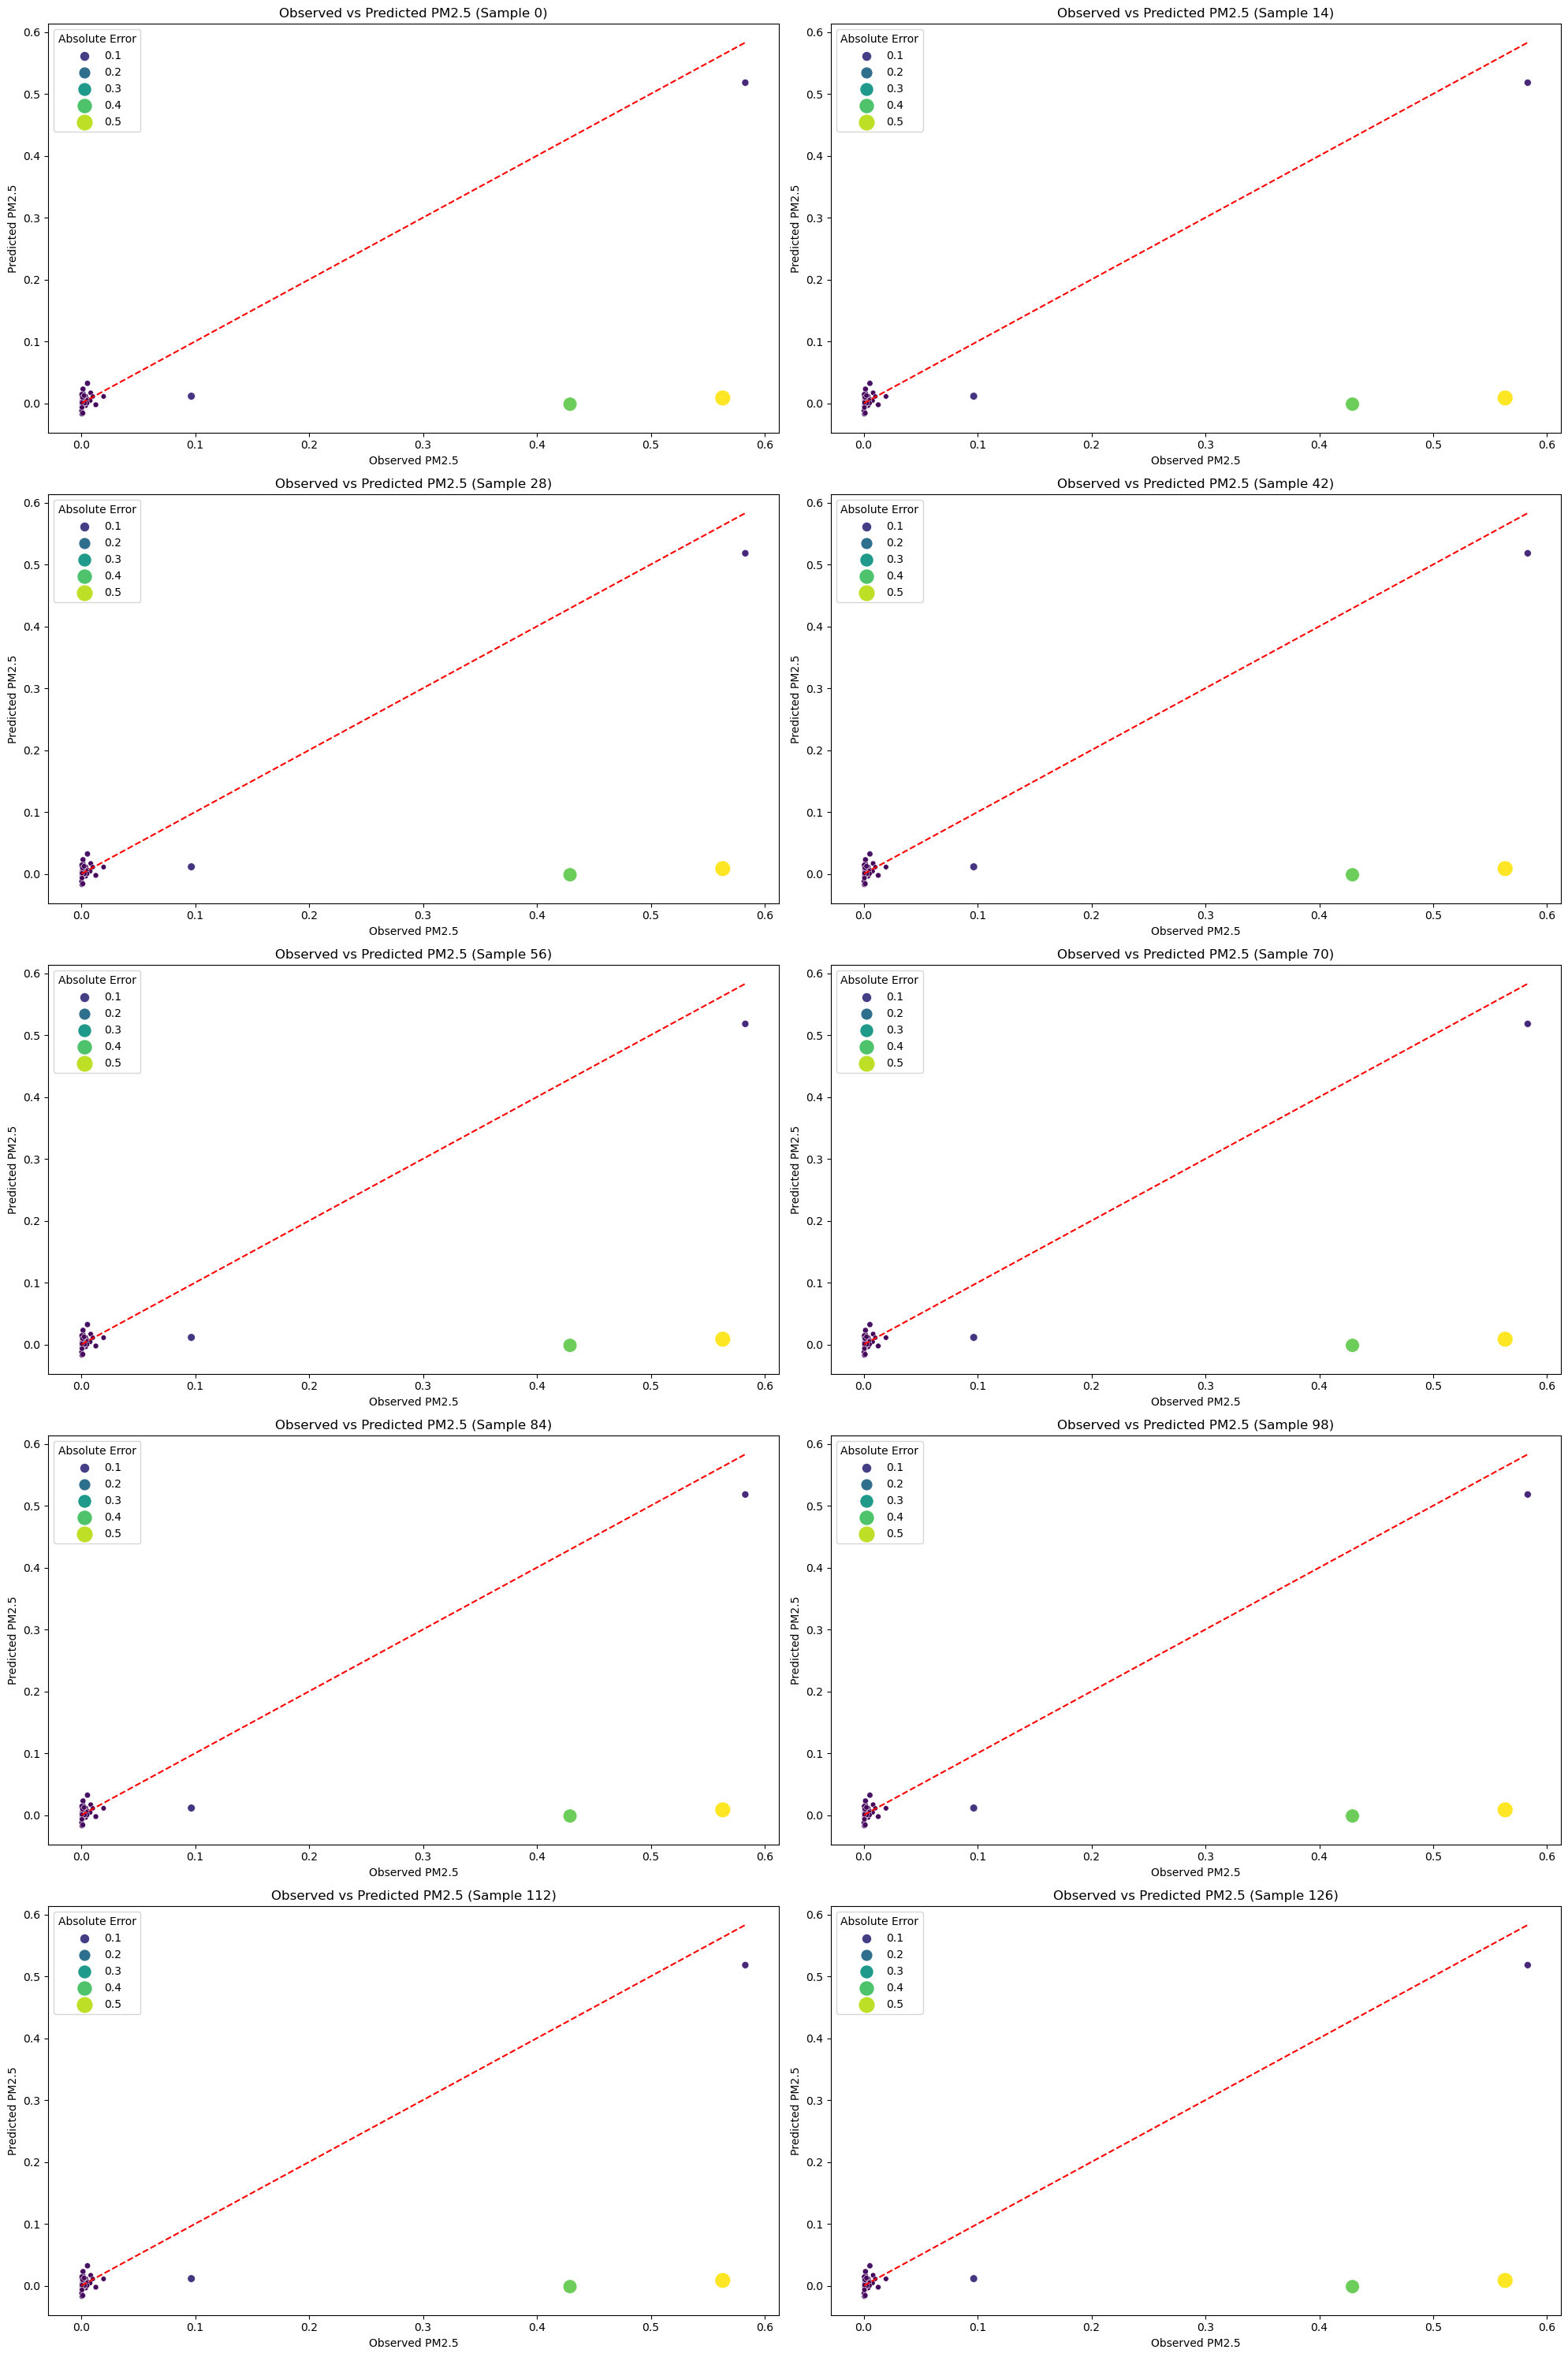

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

num_samples = 10
step_size = 14  # Set the step size to 11
rows = (num_samples + 1) // 2  # Calculate number of rows needed for 2 plots per row

fig, axes = plt.subplots(rows, 2, figsize=(20, 6 * rows))
axes = axes.flatten()  # Flatten the axes array for easy iteration

for idx, i in enumerate(range(0, num_samples * step_size, step_size)):
    # Scatter plot of observed vs predicted values
    sns.scatterplot(ax=axes[idx], x='Observed_PM2.5', y='Predicted_PM2.5', data=results_data, hue='Absolute_Error', palette='viridis', size='Absolute_Error', sizes=(20, 200))
    axes[idx].plot([results_data['Observed_PM2.5'].min(), results_data['Observed_PM2.5'].max()], [results_data['Observed_PM2.5'].min(), results_data['Observed_PM2.5'].max()], color='red', linestyle='--')
    axes[idx].set_title(f'Observed vs Predicted PM2.5 (Sample {i})')
    axes[idx].set_xlabel('Observed PM2.5')
    axes[idx].set_ylabel('Predicted PM2.5')
    axes[idx].legend(title='Absolute Error')

# Remove any unused subplots
for ax in axes[len(range(0, num_samples * step_size, step_size)):]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()